In [1]:
import os
import urllib

import pandas as pd

from cell_type_naming import nice_to_weirds, weird_to_nice

In [2]:
experiment_name = "defaults"
experiment_uri = os.path.join("gs://liulab/csx_experiments/varying_simple_parameters", experiment_name)

experiment_uri

'gs://liulab/csx_experiments/varying_simple_parameters/defaults'

In [3]:
!gsutil --quiet rm -r $experiment_uri

In [4]:
mixture_source = "gs://liulab/csx_example_files/Single_Cell_RNA-Seq_Melanoma_SuppFig_3b-d/mixture_melanoma_Tirosh_SuppFig_3b-d.txt"
# mixture_filename = os.path.basename(mixture_source)
mixture_filename = "mymixture.txt"
mixture_target = os.path.join(experiment_uri, "in", mixture_filename)

!gsutil cp $mixture_source $mixture_target

sc_refsample_source = "gs://liulab/csx_example_files/Single_Cell_RNA-Seq_Melanoma_SuppFig_3b-d/scRNA-Seq_reference_melanoma_Tirosh_SuppFig_3b-d.txt"
# sc_refsample_filename = os.path.basename(sc_refsample_source)
sc_refsample_filename = "myscrefsample.txt"
sc_refsample_target = os.path.join(experiment_uri, "in", sc_refsample_filename)

!gsutil cp $sc_refsample_source $sc_refsample_target

Copying gs://liulab/csx_example_files/Single_Cell_RNA-Seq_Melanoma_SuppFig_3b-d/mixture_melanoma_Tirosh_SuppFig_3b-d.txt [Content-Type=text/plain]...
/ [1 files][  6.0 MiB/  6.0 MiB]                                                
Operation completed over 1 objects/6.0 MiB.                                      
Copying gs://liulab/csx_example_files/Single_Cell_RNA-Seq_Melanoma_SuppFig_3b-d/scRNA-Seq_reference_melanoma_Tirosh_SuppFig_3b-d.txt [Content-Type=text/plain]...
/ [1 files][ 87.8 MiB/ 87.8 MiB]                                                
Operation completed over 1 objects/87.8 MiB.                                     


In [5]:
experiment_path = "/mnt/buckets/liulab" + urllib.parse.urlparse(experiment_uri).path

In [6]:
!tree -h $experiment_path

/mnt/buckets/liulab/csx_experiments/varying_simple_parameters/defaults
└── [   0]  in
    ├── [6.0M]  mymixture.txt
    └── [ 88M]  myscrefsample.txt

1 directory, 2 files


In [7]:
command = f'''docker run \
    --rm \
    -v {experiment_path}/in:/src/data \
    -v {experiment_path}:/src/outdir \
    --user "$(id -u):$(id -g)" \
    cibersortx/fractions:latest \
    --username lyronctk@stanford.edu \
    --token dfeba2c8b9d61daebee5fa87026b8e56 \
    --single_cell TRUE \
    --refsample {sc_refsample_filename} \
    --mixture {mixture_filename} \
    --verbose TRUE
'''.replace("    ", " \\\n    ")
print(command)

docker run \
     --rm \
     -v /mnt/buckets/liulab/csx_experiments/varying_simple_parameters/defaults/in:/src/data \
     -v /mnt/buckets/liulab/csx_experiments/varying_simple_parameters/defaults:/src/outdir \
     --user "$(id -u):$(id -g)" \
     cibersortx/fractions:latest \
     --username lyronctk@stanford.edu \
     --token dfeba2c8b9d61daebee5fa87026b8e56 \
     --single_cell TRUE \
     --refsample myscrefsample.txt \
     --mixture mymixture.txt \
     --verbose TRUE



In [8]:
!{command}

>Running CIBERSORTxFractions...
>[Options] username: lyronctk@stanford.edu
>[Options] token: dfeba2c8b9d61daebee5fa87026b8e56
>[Options] single_cell: TRUE
>[Options] refsample: myscrefsample.txt
>[Options] mixture: mymixture.txt
>[Options] verbose: TRUE
>Making reference sample file.
>Making phenotype class file.
>single_cell is set to TRUE, so quantile normalization is set to FALSE, and the default parameters for building the signature matrix have been set to the following values:
	- G.min <- 300
	- G.max <- 500
	- q.value <- 0.01
>==========Signature Matrix Settings============
>Pure samples file: /src/outdir//CIBERSORTx_myscrefsample_inferred_refsample.txt
>Phenotype classes file: /src/outdir//CIBERSORTx_myscrefsample_inferred_phenoclasses.txt
>Minimum number of DEGs to consider from each phenotype for signature matrix set to: 300
>Maximum number of DEGs to consider from each phenotype for signature matrix set to: 500
>Q-value for signature matrix construction set to: 0.01
>Quantile

In [10]:
!tree -h $experiment_path

/mnt/buckets/liulab/csx_experiments/varying_simple_parameters/defaults
├── [4.3K]  CIBERSORTx_Results.txt
├── [3.8M]  CIBERSORTx_cell_type_sourceGEP.txt
├── [172K]  CIBERSORTx_myscrefsample_inferred_phenoclasses.CIBERSORTx_myscrefsample_inferred_refsample.bm.K999.pdf
├── [510K]  CIBERSORTx_myscrefsample_inferred_phenoclasses.CIBERSORTx_myscrefsample_inferred_refsample.bm.K999.txt
├── [ 725]  CIBERSORTx_myscrefsample_inferred_phenoclasses.txt
├── [ 18M]  CIBERSORTx_myscrefsample_inferred_refsample.txt
└── [   0]  in
    ├── [6.0M]  mymixture.txt
    └── [ 88M]  myscrefsample.txt

1 directory, 8 files


In [11]:
fractions_csx = pd.read_csv(
    os.path.join(experiment_uri, "CIBERSORTx_Results.txt"),
    sep="\t",
    index_col=0
).rename_axis(index="mixture_id").rename(columns=weird_to_nice).iloc[:, :-3]

fractions_csx.sample(5)

,Malignant,Endothelial,CAF,T CD8,NK,Macrophage,T CD4,B
mixture_id,,,,,,,,
79,0.535874,0.012133,0.002669,0.252050,0.000000,0.030821,0.114126,0.052326
65,0.059540,0.000000,0.000411,0.309446,0.028671,0.027971,0.485839,0.088122
71,0.438077,0.000467,0.001840,0.372297,0.025173,0.033532,0.128481,0.000134
81,0.387165,0.005089,0.035240,0.256899,0.025997,0.013439,0.265311,0.010861
58,0.000000,0.000000,0.002111,0.697889,0.061412,0.014088,0.214017,0.010482


In [12]:
signature_matrix = pd.read_csv(
    os.path.join(experiment_uri, "CIBERSORTx_myscrefsample_inferred_phenoclasses.CIBERSORTx_myscrefsample_inferred_refsample.bm.K999.txt"),
    sep="\t",
    index_col=0
).rename_axis(index="gene").rename(columns=weird_to_nice)

signature_matrix.sample(5)

,Malignant,Endothelial,CAF,T CD8,NK,Macrophage,T CD4,B
gene,,,,,,,,
VCL,17.369503,40.528505,150.085155,1.0,1.0,1.0,1.0,1.000000
CNIH3,66.169238,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000
SLC2A6,1.000000,1.000000,27.123860,1.0,1.0,1.0,1.0,71.996092
CFH,1.000000,1.000000,107.728654,1.0,1.0,1.0,1.0,1.000000
TNFRSF12A,74.327998,1.000000,591.940021,1.0,1.0,1.0,1.0,1.000000


In [13]:
fractions_truth = pd.read_csv(
    "gs://liulab/csx_example_files/groundtruth_Melanoma_Tirosh_et_al_SuppFig3b-d.txt",
    sep="\t",
    index_col=0,
).rename_axis(index="mixture_id").rename(columns=weird_to_nice)

fractions_truth.sample(5)

,Malignant,Endothelial,CAF,T CD8,NK,Macrophage,T CD4,B
mixture_id,,,,,,,,
75,0.0087,0.0000,0.0000,0.9417,0.0000,0.0029,0.0466,0.0000
78,0.9756,0.0000,0.0081,0.0000,0.0000,0.0000,0.0081,0.0081
94,0.0413,0.0785,0.0661,0.2025,0.0041,0.0083,0.3306,0.2686
88,0.3966,0.0000,0.0068,0.1559,0.0305,0.1356,0.2203,0.0542
89,0.2263,0.0023,0.0000,0.3141,0.0023,0.0600,0.1501,0.2448


In [19]:
import plotly.io
plotly.io.renderers.default = "jupyterlab+png"

import plotly.express as px
import plotly.graph_objects as go

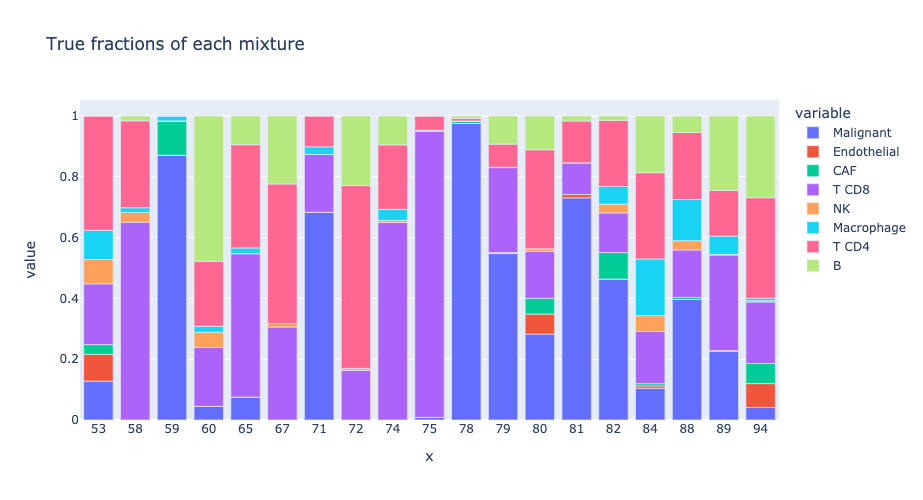

In [20]:
fig = px.bar(
    fractions_truth,  #.astype(index={"mixture_id": str}),
    x=fractions_truth.index.astype(str),
    y=fractions_truth.columns,
    title="True fractions of each mixture"
)

fig.show()

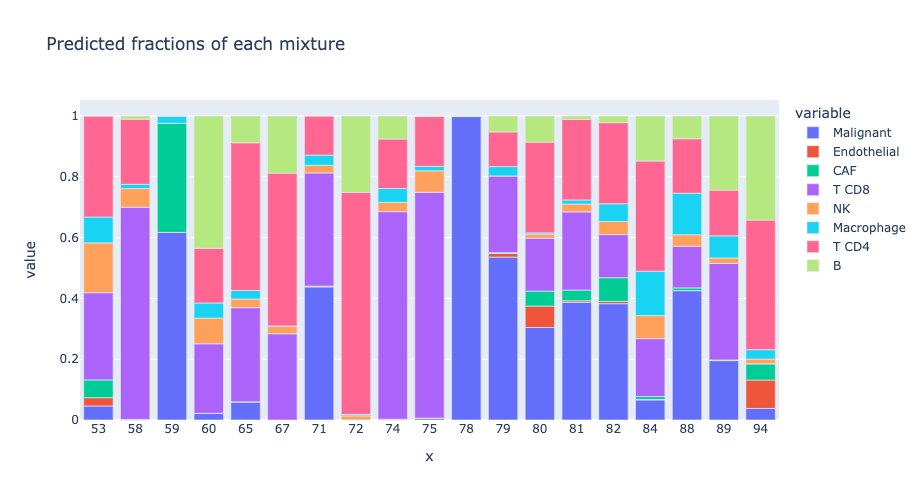

In [21]:
fig = px.bar(
    fractions_csx,  #.astype(index={"mixture_id": str}),
    x=fractions_csx.index.astype(str),
    y=fractions_csx.columns,
    title="Predicted fractions of each mixture"
)

fig.show()